In [1]:
print("Shivaya Namah")

Shivaya Namah


In [2]:
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic_settings import BaseSettings
from langchain_ibm import ChatWatsonx


class Settings(BaseSettings): 

    pinecone_api_key: str 
    watsonx_apikey: str  
    watsonx_url: str
    watsonx_project_id: str
    cohere_api_key: str 
    tavily_api_key: str
    google_api_key: str

    langsmith_api_key: str
    langsmith_endpoint: str
    langsmith_tracing: bool
    langsmith_project: str

    class Config:
        env_file = ".env"
        extra = "ignore"

settings = Settings()
print("API Keys loaded succesfully.")

API Keys loaded succesfully.


In [3]:
llm = ChatWatsonx(
    apikey = settings.watsonx_apikey,
    project_id = settings.watsonx_project_id,
    url = settings.watsonx_url,
    temperature = 0.9,
    model_id = "ibm/granite-3-3-8b-instruct"
)
llm

ChatWatsonx(model_id='ibm/granite-3-3-8b-instruct', project_id='25fa768b-a90b-433c-b4a4-66bb407af16b', url=SecretStr('**********'), apikey=SecretStr('**********'), params={'temperature': 0.9}, temperature=0.9, watsonx_model=<ibm_watsonx_ai.foundation_models.inference.model_inference.ModelInference object at 0x000002093C75DFD0>)

In [4]:
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert AI Researcher. Current Time {current_time} "
            "1, {initial_instruction} "
            "2, Reflect and critique your answer. Be serve to maximize improvement. "
            "3, After the reflection, **list 1-3 search queries separately** for researching improvements. Do not include them inside the reflection. "
        ),
        (
            "system",
            "Answer the user's question above usin the required format. "
            "You must always return valid JSON fenced by a markdown code block. Do not return any additional text."
            # We instructing the llm to return the result in a JSON format, but not a actual json object. llm mostly return str object. But we need a
            # proper json format even it is a str, that will help us to parse in PydanticToolsParser to get a str result as JSON/Pydantic scheme.
        ),
        MessagesPlaceholder(variable_name = "messages"),

    ]
)
actor_prompt_template

ChatPromptTemplate(input_variables=['current_time', 'initial_instruction', 'messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk'

In [5]:
actor_prompt_template.partial(current_time="Time", initial_instruction="Hi")

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [6]:
from pydantic import BaseModel, Field

class Reflection(BaseModel):
    "Represents the Reflection"
    missing: str = Field(description = "Critique of what is missing.")
    superfluous: str = Field(description = "Critique of what is superfluous.")


class AnswerQuestion(BaseModel):
    "Represents the Answer"
    answer: str = Field(description = "250 words of detailed answer to this question.")
    search_queries: list[str] = Field(
        description = "1-3 search queries for researching improvements" \
        " to address the citique of your current answer."
    )
    reflection: Reflection = Field(description = "Your reflection to the initial answer.")

In [7]:
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from datetime import datetime

responder_chain = (
    actor_prompt_template.partial(current_time = datetime.now().isoformat(), initial_instruction = "Provide a details 250 words of answer. ") 
    | llm.bind_tools(tools = [AnswerQuestion], tool_choice = "AnswerQuestion")
    | PydanticToolsParser(tools = [AnswerQuestion])
)

responder_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [8]:
type(responder_chain)

langchain_core.runnables.base.RunnableSequence

In [11]:
resp = "{\n\"answer\": \"## How Small Businesses Can Leverage AI for Growth\\n\\nThe integration of Artificial Intelligence (AI) is no longer confined to large corporations and tech-forward companies. Small businesses can and should also harness the power of AI to enhance operations, improve customer experiences, and drive growth. This post explores actionable ways small businesses can leverage AI to foster expansion and stay competitive in an increasingly digital and data-driven marketplace.\\n\\n### 1. Enhancing Customer Service with AI Chatbots\\n\\nSmall businesses can significantly improve customer engagement and satisfaction by implementing AI-driven chatbots on their websites. These chatbots provide 24/7 support, answering frequently asked questions, guiding customers through services, and collecting essential data. This not only ensures a seamless customer experience but also alleviates the workload on human customer service representatives, allowing them to focus on complex issues requiring a human touch.\\n\\n#### Search Queries for Improvement:\\n1. 'Latest AI chatbot platforms for small businesses'\\n2. 'Case studies of small businesses using chatbots effectively'\\n3. 'Regulatory considerations for AI chatbots in customer service'\\n\\n### 2. Personalizing Marketing with AI Analytics\\n\\nAI algorithms can analyze customer data to identify patterns and preferences, enabling small businesses to personalize their marketing efforts. By segmenting audiences based on behavior, demographics, and interests, businesses can tailor content to resonate more effectively. Personalized marketing does not only enhance engagement but can also lead to higher conversion rates.\\n\\n#### Critique:\\n*Missing*: Specific examples of AI tools small businesses could utilize for personalized marketing.\\n*Superfluous*: The explanation of personalization benefits could be more detailed with statistics or case studies.*\\n\\n#### Search Queries for Improvement:\\n1. 'AI tools for personalized marketing on a budget'\\n2. 'Case study: Small business success with AI-driven marketing'\\n3. 'Metrics for measuring the ROI of AI-driven marketing initiatives in small businesses'\\n\\n### 3. Optimizing Operations through Predictive Analytics\\n\\nBy using predictive analytics, small businesses can forecast trends, optimize inventory management, and reduce operational costs. AI models can analyze sales data, seasonal patterns, and external factors to predict future demand accurately. This helps in minimizing overstocking or stockouts, ultimately improving cash flow and customer satisfaction.\\n\\n#### Search Queries for Improvement:\\n1. 'Best AI tools for predictive analytics for small businesses'\\n2. 'Examples of inventory management success with AI'\\n3. 'Data security considerations in AI predictive analytics for SMBs'\\n\\n### 4. Streamlining HR Processes with AI\\n\\nAI can also play a role in human resource management for small businesses. AI-driven applicant tracking systems (ATS) can screen resumes more efficiently than manual methods, reducing bias and saving time. Additionally, AI can aid in workforce planning and talent development by identifying skill gaps and suggesting training programs.\\n\\n#### Critique:\\n*Superfluous*: While discussing AI in HR, mentioning the ethical considerations regarding AI decision-making in recruitment could add depth.*\\n\\n#### Search Queries for Improvement:\\n1. 'Ethical considerations in using AI for recruitment'\\n2. 'Best affordable AI-based ATS for SMBs'\\n3. 'Case studies on AI enhancing workforce development in small companies'\\n\\n### Conclusion\\n\\nSmall businesses have much to gain by strategically incorporating AI into their operations. From enhanced customer service through chatbots to optimizing HR with AI tools, the potential applications are vast. As AI technology becomes more accessible and affordable, small business owners should consider integrating it into their growth strategies. However, it's crucial to approach AI adoption thoughtfully, focusing on solutions that address specific business needs and align with overall goals.\\n\\n###### Reflection:\\n*Missing*: More concrete examples of AI tools tailored for small businesses, including pricing and features. \\n*Superfluous*: The blog post could benefit from more interactive elements such as infographics or a downloadable checklist of AI applications for small businesses.\",\n\"reflection\": {\n    \"missing\": \"The response could benefit from specific AI tool recommendations tailored for small businesses, including their pricing and features to make the suggestions more actionable.\",\n    \"superfluous\": \"While the blog post's content is comprehensive, some sections could be more concrete"
print(resp)


{
"answer": "## How Small Businesses Can Leverage AI for Growth\n\nThe integration of Artificial Intelligence (AI) is no longer confined to large corporations and tech-forward companies. Small businesses can and should also harness the power of AI to enhance operations, improve customer experiences, and drive growth. This post explores actionable ways small businesses can leverage AI to foster expansion and stay competitive in an increasingly digital and data-driven marketplace.\n\n### 1. Enhancing Customer Service with AI Chatbots\n\nSmall businesses can significantly improve customer engagement and satisfaction by implementing AI-driven chatbots on their websites. These chatbots provide 24/7 support, answering frequently asked questions, guiding customers through services, and collecting essential data. This not only ensures a seamless customer experience but also alleviates the workload on human customer service representatives, allowing them to focus on complex issues requiring a h

In [12]:
response = responder_chain.invoke(
    {"messages": [HumanMessage(content = "Write me a blog post on how small business can leverage AI to grow.")]}
)

In [14]:
response

[AnswerQuestion(answer="Title: Harnessing the Power of AI for Small Business Growth\n\nArtificial Intelligence (AI) is no longer a futuristic concept; it's a current reality with vast potential for small businesses. Here's how small businesses can leverage AI to fuel their growth.\n\n**1. Streamline Operations with AI-Driven Automation**\nAI can automate routine and time-consuming tasks, allowing small business owners to focus on strategic planning and customer engagement. For instance, AI chatbots can manage customer inquiries 24/7, while AI-powered analytics tools can automate reporting and data analysis.\n\n**2. Enhance Customer Experience through Personalization**\nAI algorithms can analyze customer data and purchasing patterns to offer personalized recommendations and tailored marketing messages. This level of personalization can increase customer satisfaction and loyalty, leading to higher retention rates and sales.\n\n**3. Optimize Pricing and Inventory Management**\nAI-driven p

In [18]:
print(type(response)) 
print(type(response[0]))

<class 'list'>
<class '__main__.AnswerQuestion'>


In [22]:
print(response[0].model_dump_json(indent = 4))

{
    "answer": "Title: Harnessing the Power of AI for Small Business Growth\n\nArtificial Intelligence (AI) is no longer a futuristic concept; it's a current reality with vast potential for small businesses. Here's how small businesses can leverage AI to fuel their growth.\n\n**1. Streamline Operations with AI-Driven Automation**\nAI can automate routine and time-consuming tasks, allowing small business owners to focus on strategic planning and customer engagement. For instance, AI chatbots can manage customer inquiries 24/7, while AI-powered analytics tools can automate reporting and data analysis.\n\n**2. Enhance Customer Experience through Personalization**\nAI algorithms can analyze customer data and purchasing patterns to offer personalized recommendations and tailored marketing messages. This level of personalization can increase customer satisfaction and loyalty, leading to higher retention rates and sales.\n\n**3. Optimize Pricing and Inventory Management**\nAI-driven pricing 

In [22]:
response = responder_chain.invoke(
    {"messages": [HumanMessage(content = "Write me a blog post on how LangChain and LangGraph extremly helps to build efficient AI Agents.")]}
)

In [74]:
print(response[0].model_dump_json(indent = 4))

{
    "answer": "Title: Revolutionizing AI Agent Efficiency with LangChain and LangGraph\n\nIn the rapidly advancing field of artificial intelligence (AI), the creation of efficient AI agents capable of managing extensive linguistic data has become paramount. LangChain and LangGraph stand out as two pivotal tools driving this transformation.\n\n**LangChain and LangGraph: An Overview**\n\nLangChain is a progressive framework offering model orchestration, particularly beneficial for sophisticated natural language processing (NLP) tasks. It efficiently directs the interaction and data flow among numerous ML models, forming the backbone of robust AI agents. LangGraph, conversely, introduces a graph-based representation of language, significantly enhancing AI systems' ability to grasp contextual semantics and syntactic relationships within textual information.\n\n**Boosting AI Agent Efficiency**\n\n1. *Streamlined Workflow with LangChain*: LangChain's prowess in managing intricate model wor

Clear comparison of **PydanticOutputParser** and **PydanticToolsParser**, their advantages, and when to use each:

---

## 🧩 **PydanticOutputParser**

**What it is**:
A LangChain **output parser** that transforms LLM-generated JSON-like text into a **Pydantic model** instance (`BaseModel`). It validates and coerces types automatically. ([LangChain][1], [LangChain][2])

**Advantages**:

* **Structured outputs**: Ensures responses conform to your defined schema.
* **Validation logic**: Use Pydantic validators (e.g., check formats, default values).
* **Error handling**: Throws clear errors if output fails validation.
* **Streaming support**: Can output diffs for real-time parsing. ([LangChain][1])

**Use Cases**:

* Extracting structured data (dates, numbers, lists) from LLM responses.
* Automating data ingestion pipelines.
* Wrapping LLMs in type-safe APIs.

---

## 🔧 **PydanticToolsParser**

**What it is**:
A specialized **tool-output parser** designed to parse LLM responses that represent a **sequence of tool calls** into Python structures. It expects the LLM to output multiple tools with arguments, then transforms that JSON into Pydantic-style objects. ([LangChain][3])

**Advantages**:

* **Tool orchestration**: Cleanly parse when LLM suggests multiple tool invocations.
* **Schema compliance**: Ensures each tool call and its arguments match expected layout.
* **Better integration**: Fits into multi-tool agent workflows.

**Use Cases**:

* Agents that output actions like `search()`, `get_weather()`, then arguments.
* When you want to parse complex, multi-step instruction outputs.

---

## 📊 Quick Comparison

| Feature                | PydanticOutputParser                                                 | PydanticToolsParser                                              |
| ---------------------- | -------------------------------------------------------------------- | ---------------------------------------------------------------- |
| **Purpose**            | Convert LLM text → one typed model (`BaseModel`)                     | Convert LLM text → sequence of tool call objects                 |
| **Schema enforcement** | Validates single structured response                                 | Validates multi-step tool-call structure                         |
| **Integrates with**    | Prompt chains, parsing text output to a Pydantic class               | Agent/tool frameworks (OpenAI tool-calling styles)               |
| **Streaming support**  | Yes — supports diffs or full models ([LangChain][4], [LangChain][1]) | Not specifically mentioned — focused on parsing completed output |

---

## ✅ When to Use Which

* **Use PydanticOutputParser** when:

  * You need to extract structured data (e.g., a JSON report, form input) from the model.
  * You want extra validation or defaulting logic in your flow.

* **Use PydanticToolsParser** when:

  * The model responds with multiple tool calls (e.g., "tool A with these args, then tool B...").
  * You're building an agent that interprets LLM-generated actions as concrete tool invocation steps.

---

## ⚙️ Real-World Benefits

1. **Reliability**: Forces LLM outputs into strict, expected formats.
2. **Maintainsability**: Single source of truth for expected output shapes.
3. **Error surface**: Detects many issues (e.g., missing fields, wrong types) early.
4. **Integration-friendly**: Fits neatly into pipelines or agent frameworks.
5. **Readability**: Downstream code uses `.field_name`, not nested JSON parsing.

---

**Summary**:

* Choose **PydanticOutputParser** to extract a structured object (like a user profile, financial summary, or config).
* Choose **PydanticToolsParser** when the LLM output represents a series of **callable instructions or tool invocations**, and you want them parsed cleanly.


[1]: https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.pydantic.PydanticOutputParser.html?utm_source=chatgpt.com "PydanticOutputParser — LangChain documentation"
[2]: https://lagnchain.readthedocs.io/en/stable/modules/prompts/output_parsers/examples/pydantic.html?utm_source=chatgpt.com "PydanticOutputParser — LangChain 0.0.149 - Read the Docs"
[3]: https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.openai_tools.PydanticToolsParser.html?utm_source=chatgpt.com "PydanticToolsParser — LangChain documentation"
[4]: https://python.langchain.com/docs/concepts/output_parsers/?utm_source=chatgpt.com "Output parsers - ️ LangChain"


## ✅ `llm.with_structured_output(schema=Profile)`

### ✅ Internally uses:

**`PydanticOutputParser`**

* The `Profile` class is treated as the schema for a **single structured output**.
* It **expects** the LLM to return a response that matches the `Profile` model directly.
* The parsed result will be returned as a `Profile` instance — ready to use.

### 💡 Behavior:

* Works great for **one-shot** LLM calls where the **entire output** is meant to be parsed into a single Pydantic object.
* **Output is single Pydantic object**, not in any nested field.

---

## ⚠️ `llm.bind_tools(tools=[Profile], tool_choice="Profile")`

### Internally designed for:

**Tool calling style output**
(Like OpenAI function-calling / tool-calling format)

* The model returns **tool invocation JSON**, e.g.:

  ```json
  {
    "tool_calls": [
      {
        "function": {
          "name": "Profile",
          "arguments": {
            "name": "Alice",
            "age": 30
          }
        }
      }
    ]
  }
  ```

* This format **does NOT go into `response.content`**, but instead lands in:

  ```python
  response.additional_kwargs["tool_calls"]
  ```

---

## ❌ Why `PydanticOutputParser` fails here

* `PydanticOutputParser` expects raw output like:

  ```json
  {
    "name": "Alice",
    "age": 30
  }
  ```

* But `bind_tools()` yields a **wrapped structure** under `tool_calls`, not the plain Pydantic model — so the parser **can’t find the expected fields**.

---

## ✅ Why `PydanticToolsParser` is correct

* `PydanticToolsParser` knows how to parse the OpenAI-style **tool\_calls** structure.
* It locates the correct tool name (`Profile`) and unpacks the arguments into a proper `Profile` instance.

---

### 🔁 Summary

| Method                                | Parser Used              | Expected Output Format        | Response Field                             |
| ------------------------------------- | ------------------------ | ----------------------------- | ------------------------------------------ |
| `llm.with_structured_output(Profile)` | ✅ `PydanticOutputParser` | Just the Pydantic model       | `response.content`                         |
| `llm.bind_tools(tools=[Profile])`     | ✅ `PydanticToolsParser`  | Tool-call JSON (OpenAI-style) | `response.additional_kwargs["tool_calls"]` |

---

### 🧪 Pro Tip

If you want to extract and validate the tool output from `llm.bind_tools(...)`, do:

```python
from langchain.output_parsers.openai_tools import PydanticToolsParser

parser = PydanticToolsParser(tools=[Profile])
parsed = parser.parse_result(llm_response)
```



## Revisor Chain Building

In [23]:
revise_instructions: str = """
    Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
    - Your MUST include numerical citations in your revised answer to measure it can be verified.
    - Add a "References" section to the bottom of your answer(which does not count towards the word limit). In form of
        - [1] https://example1.com
        - [2] https://example2.com
    -You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.

"""
print(revise_instructions)


    Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
    - Your MUST include numerical citations in your revised answer to measure it can be verified.
    - Add a "References" section to the bottom of your answer(which does not count towards the word limit). In form of
        - [1] https://example1.com
        - [2] https://example2.com
    -You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.




In [24]:
class ReviseAnswer(AnswerQuestion):
    "Represents the ReviseAnswer schema."
    citations: list[str] = Field(
        description = "Citations motivating your updated answer."
    ) 

In [64]:
revisor_chain = (
    actor_prompt_template.partial(
        current_time = datetime.now().isoformat(),
        initial_instruction = revise_instructions
    )
    | llm.bind_tools(tools = [ReviseAnswer], tool_choice = "ReviseAnswer")
    # | PydanticToolsParser(tools = [ReviseAnswer])
)
revisor_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [65]:
previous_response = {
    "answer": "Title: Revolutionizing AI Agent Efficiency with LangChain and LangGraph\n\nThe realm of artificial intelligence (AI) is constantly evolving, and recent advancements have placed significant emphasis on building autonomous AI agents capable of efficiently processing and utilizing vast amounts of linguistic data. Two instrumental tools driving this revolution are LangChain and LangGraph.\n\n**Understanding LangChain and LangGraph**\n\nLangChain, an innovative framework, facilitates the orchestration of machine learning (ML) models, specifically tailored for natural language processing (NLP) tasks. It efficiently handles complex workflows involving multiple NLP models, allowing seamless interaction and data exchange, and thus, paving the way for robust AI agents. On the other hand, LangGraph represents a graph-based representation of language, enabling AI systems to capture the contextual semantics and syntactic relationships within text data more effectively.\n\n**Efficiency in AI Agents via LangChain and LangGraph**\n\n1. *Orchestration and Workflow Management*: LangChain's ability to manage the intricate workflows of multiple NLP models ensures an organized and efficient processing of linguistic data. This streamlined approach reduces latency and enhances the overall performance of AI agents. By enabling modular and scalable architectures, LangChain ensures that AI agents can adapt and grow with increasing data complexity and model sophistication.\n\n2. *Enhanced Contextual Understanding through LangGraph*: LangGraph's capability to model language as a graph allows AI agents to harness contextual information more effectively. This contextual awareness dramatically improves the accuracy and relevance of AI agents' responses, as they can draw upon nuanced relationships between words and phrases within a text. Consequently, this elevates the quality of interactions and the utility of AI agents in various applications.\n\n3. *Scalability and Flexibility*: Both LangChain and LangGraph are built with scalability in mind. As an AI agent's requirements grow, these tools can accommodate new models and expand existing ones, ensuring that performance doesn't plateau. This adaptability makes them ideal for developing AI agents capable of handling diverse tasks across varied domains.\n\n**Real-world Applications and Impact**\n\nThe synergy between LangChain and LangGraph holds immense potential across industries. In customer service, AI agents equipped with these tools can offer nuanced, contextually relevant responses, enhancing user satisfaction. In content generation, such agents can produce more coherent and contextually accurate text. Furthermore, in knowledge management sectors, LangChain and LangGraph can empower AI agents to efficiently extract, synthesize, and communicate critical information.\n\n**Conclusion**\n\nLangChain and LangGraph are transformative tools that significantly bolster the efficiency of AI agents. By providing robust orchestration, context-aware processing, and exceptional scalability, they unlock new frontiers in AI capability. As research in this space progresses, the seamless integration of these technologies promises even more refined and capable AI agents, further blurring the lines between human-machine interaction.",
    "search_queries": [
        "LangChain AI agent examples",
        "LangGraph use cases",
        "Contextual AI agent efficiency benchmarks"
    ],
    "reflection": {
        "missing": "The blog post lacks real-world case studies or specific examples of AI agents utilizing LangChain and LangGraph, which could better demonstrate their practical application and impact.",
        "superfluous": "The explanation of LangChain and LangGraph's functionalities can be condensed to reduce redundancy and maintain focus on their utility in AI agent development."
    }
}
AIMessage([previous_response])

AIMessage(content=[{'answer': "Title: Revolutionizing AI Agent Efficiency with LangChain and LangGraph\n\nThe realm of artificial intelligence (AI) is constantly evolving, and recent advancements have placed significant emphasis on building autonomous AI agents capable of efficiently processing and utilizing vast amounts of linguistic data. Two instrumental tools driving this revolution are LangChain and LangGraph.\n\n**Understanding LangChain and LangGraph**\n\nLangChain, an innovative framework, facilitates the orchestration of machine learning (ML) models, specifically tailored for natural language processing (NLP) tasks. It efficiently handles complex workflows involving multiple NLP models, allowing seamless interaction and data exchange, and thus, paving the way for robust AI agents. On the other hand, LangGraph represents a graph-based representation of language, enabling AI systems to capture the contextual semantics and syntactic relationships within text data more effectively

In [66]:
import json 

json.loads(json.dumps(previous_response))

{'answer': "Title: Revolutionizing AI Agent Efficiency with LangChain and LangGraph\n\nThe realm of artificial intelligence (AI) is constantly evolving, and recent advancements have placed significant emphasis on building autonomous AI agents capable of efficiently processing and utilizing vast amounts of linguistic data. Two instrumental tools driving this revolution are LangChain and LangGraph.\n\n**Understanding LangChain and LangGraph**\n\nLangChain, an innovative framework, facilitates the orchestration of machine learning (ML) models, specifically tailored for natural language processing (NLP) tasks. It efficiently handles complex workflows involving multiple NLP models, allowing seamless interaction and data exchange, and thus, paving the way for robust AI agents. On the other hand, LangGraph represents a graph-based representation of language, enabling AI systems to capture the contextual semantics and syntactic relationships within text data more effectively.\n\n**Efficiency i

In [67]:
response = revisor_chain.invoke(
    {
        "messages":  [
            HumanMessage(content = "Write me a blog post on how LangChain and LangGraph extremly helps to build efficient AI Agents."),
            AIMessage(content = json.dumps(previous_response)), # Change the dictonary or json like object into json like string to work with LLM.
        ]
    }
)

In [68]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-b8c9e4988fb940deb61a3de245b54ecc', 'type': 'function', 'function': {'name': 'ReviseAnswer', 'arguments': '{"answer": "Title: Elevating AI Agent Capabilities with LangChain and LangGraph\\n\\nIn the dynamic landscape of artificial intelligence (AI), the development of efficient AI agents is paramount. Two key tools that are catalyzing this progress are LangChain and LangGraph. This article elucidates how these technologies bolster AI agents\' efficiency, scalability, and contextual understanding.\\n\\n**LangChain and LangGraph: An Overview**\\n\\nLangChain is an advanced framework designed for orchestrating machine learning (ML) models, with a special emphasis on natural language processing (NLP). It excels in managing complex workflows that involve multiple NLP models, ensuring smooth interaction and data exchange. Meanwhile, LangGraph represents a novel approach to language representation through graph model

In [69]:
response.to_json()

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'messages', 'AIMessage'],
 'kwargs': {'content': '',
  'additional_kwargs': {'tool_calls': [{'id': 'chatcmpl-tool-b8c9e4988fb940deb61a3de245b54ecc',
     'type': 'function',
     'function': {'name': 'ReviseAnswer',
      'arguments': '{"answer": "Title: Elevating AI Agent Capabilities with LangChain and LangGraph\\n\\nIn the dynamic landscape of artificial intelligence (AI), the development of efficient AI agents is paramount. Two key tools that are catalyzing this progress are LangChain and LangGraph. This article elucidates how these technologies bolster AI agents\' efficiency, scalability, and contextual understanding.\\n\\n**LangChain and LangGraph: An Overview**\\n\\nLangChain is an advanced framework designed for orchestrating machine learning (ML) models, with a special emphasis on natural language processing (NLP). It excels in managing complex workflows that involve multiple NLP models, ensuring smooth interacti

In [71]:
response.tool_calls

[{'name': 'ReviseAnswer',
  'args': {'answer': "Title: Elevating AI Agent Capabilities with LangChain and LangGraph\n\nIn the dynamic landscape of artificial intelligence (AI), the development of efficient AI agents is paramount. Two key tools that are catalyzing this progress are LangChain and LangGraph. This article elucidates how these technologies bolster AI agents' efficiency, scalability, and contextual understanding.\n\n**LangChain and LangGraph: An Overview**\n\nLangChain is an advanced framework designed for orchestrating machine learning (ML) models, with a special emphasis on natural language processing (NLP). It excels in managing complex workflows that involve multiple NLP models, ensuring smooth interaction and data exchange. Meanwhile, LangGraph represents a novel approach to language representation through graph models, offering a more intuitive way to capture contextual and syntactic relationships within text data.\n\n**Boosting AI Agent Efficiency**\n\n1. *Workflow Or

### Tool Execution

In [35]:
from langchain_tavily import TavilySearch
import json 
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, BaseMessage
from typing import Any

In [36]:
tavily_tool = TavilySearch(
    max_results = 3,
    tavily_api_key = settings.tavily_api_key
)

In [37]:
search_result = tavily_tool.invoke("langgraph")

In [38]:
search_result

{'query': 'langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://github.com/langchain-ai/langgraph',
   'title': 'langchain-ai/langgraph: Build resilient language agents as graphs.',
   'content': 'GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. langchain-ai.github.io/langgraph/ Trusted by companies shaping the future of agents – including Klarna, Replit, Elastic, and more – LangGraph is a low-level orchestration framework for building, managing, and deploying long-running, stateful agents. Or, to learn how to build an agent workflow with a customizable architecture, long-term memory, and other complex task handling, see the LangGraph basics tutorials. LangGraph provides low-level supporting infrastructure for _any_ long-running, stateful workflow or agent. While LangGraph can be used standalone, it also integrates seamlessly with any LangChain product, giving developers a full suite of tools for building age

In [39]:
type(search_result)

dict

In [40]:
search_result["results"]

[{'url': 'https://github.com/langchain-ai/langgraph',
  'title': 'langchain-ai/langgraph: Build resilient language agents as graphs.',
  'content': 'GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. langchain-ai.github.io/langgraph/ Trusted by companies shaping the future of agents – including Klarna, Replit, Elastic, and more – LangGraph is a low-level orchestration framework for building, managing, and deploying long-running, stateful agents. Or, to learn how to build an agent workflow with a customizable architecture, long-term memory, and other complex task handling, see the LangGraph basics tutorials. LangGraph provides low-level supporting infrastructure for _any_ long-running, stateful workflow or agent. While LangGraph can be used standalone, it also integrates seamlessly with any LangChain product, giving developers a full suite of tools for building agents. *   LangGraph Platform — Deploy and scale agents effortlessly with a purpose-built deployment 

In [44]:
print(search_result["results"][0]["content"])

GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. langchain-ai.github.io/langgraph/ Trusted by companies shaping the future of agents – including Klarna, Replit, Elastic, and more – LangGraph is a low-level orchestration framework for building, managing, and deploying long-running, stateful agents. Or, to learn how to build an agent workflow with a customizable architecture, long-term memory, and other complex task handling, see the LangGraph basics tutorials. LangGraph provides low-level supporting infrastructure for _any_ long-running, stateful workflow or agent. While LangGraph can be used standalone, it also integrates seamlessly with any LangChain product, giving developers a full suite of tools for building agents. *   LangGraph Platform — Deploy and scale agents effortlessly with a purpose-built deployment platform for long running, stateful workflows. langchain-ai.github.io/langgraph/


In [111]:
# Function to extract search queries from AnswerQuestion tool calls.
def execute_tools(state: list[BaseMessage]) -> list[BaseMessage]:

    last_ai_message: AIMessage = state[-1]

    # Extract tool calls from AI Message
    if not hasattr(last_ai_message, "tool_calls") or not last_ai_message.tool_calls:
        return []
    
    tool_messages = []

    for tool_call in last_ai_message.tool_calls:
        if tool_call["name"] in ["AnswerQuestion", "ReviseAnswer"]:
            call_id = tool_call["id"]
            search_queries = tool_call["args"].get("search_queries", [])

            # EXECUTE EACH SEARCH QUERY USING TAVILY.
            query_results = {}
            for query in search_queries:
                query_result: dict = tavily_tool.invoke(query)
                query_results[query] = query_result

            # Create a tool message with the results.
            tool_messages.append(
                ToolMessage(
                    content = json.dumps(query_results),
                    tool_call_id = call_id
                )
            )

    return tool_messages
            
                 

### Creating chain again without Parsers, since we use the AIMessage instead of Pydantic Model output. 

In [123]:
responder_chain = (
    actor_prompt_template.partial(current_time = datetime.now().isoformat(), initial_instruction = "Provide a details 250 words of answer. ") 
    | llm.bind_tools(tools = [AnswerQuestion], tool_choice = "AnswerQuestion")
)

revisor_chain = (
    actor_prompt_template.partial(current_time = datetime.now().isoformat(), initial_instruction = revise_instructions)
    | llm.bind_tools(tools = [ReviseAnswer], tool_choice = "ReviseAnswer")
)

In [75]:
responder_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [76]:
revisor_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [87]:
response = responder_chain.invoke(
    {
        "messages": [HumanMessage("Write a linkedin blog in the topic of **LangGraph the Game Changer**")]
    }
)

In [105]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-d20b54da35fa40d598bd167c77dac474', 'type': 'function', 'function': {'name': 'AnswerQuestion', 'arguments': '{\n    "answer": "## Title: LangGraph - Revolutionizing Language Learning as a Game Changer ### Introduction In the ever-evolving landscape of technology, innovation often stems from creatively blending disparate fields to tackle age-old challenges. One such groundbreaking convergence is found in LangGraph, a novel game-based platform designed to transform language acquisition into an engaging and efficient experience. This blog post explores LangGraph\'s unique features, its impact on language learning, and why it stands out as a game changer in education.\\n\\n### Unconventional Approach - Combining Gaming with Linguistics\\nLangGraph distinguishes itself by integrating the compelling elements of video games with the structured demands of language learning. Traditional methods often face challenges wi

In [88]:
response.tool_calls

[{'name': 'AnswerQuestion',
  'args': {'answer': "## Title: LangGraph - Revolutionizing Language Learning as a Game Changer ### Introduction In the ever-evolving landscape of technology, innovation often stems from creatively blending disparate fields to tackle age-old challenges. One such groundbreaking convergence is found in LangGraph, a novel game-based platform designed to transform language acquisition into an engaging and efficient experience. This blog post explores LangGraph's unique features, its impact on language learning, and why it stands out as a game changer in education.\n\n### Unconventional Approach - Combining Gaming with Linguistics\nLangGraph distinguishes itself by integrating the compelling elements of video games with the structured demands of language learning. Traditional methods often face challenges with maintaining learner motivation and engagement. LangGraph addresses these issues through an interactive schema that rewards progress and encourages continuo

In [106]:
response.additional_kwargs["tool_calls"]

[{'id': 'chatcmpl-tool-d20b54da35fa40d598bd167c77dac474',
  'type': 'function',
  'function': {'name': 'AnswerQuestion',
   'arguments': '{\n    "answer": "## Title: LangGraph - Revolutionizing Language Learning as a Game Changer ### Introduction In the ever-evolving landscape of technology, innovation often stems from creatively blending disparate fields to tackle age-old challenges. One such groundbreaking convergence is found in LangGraph, a novel game-based platform designed to transform language acquisition into an engaging and efficient experience. This blog post explores LangGraph\'s unique features, its impact on language learning, and why it stands out as a game changer in education.\\n\\n### Unconventional Approach - Combining Gaming with Linguistics\\nLangGraph distinguishes itself by integrating the compelling elements of video games with the structured demands of language learning. Traditional methods often face challenges with maintaining learner motivation and engagement

In [90]:
parser = PydanticToolsParser(tools = [AnswerQuestion])
parser

PydanticToolsParser(tools=[<class '__main__.AnswerQuestion'>])

In [91]:
parser.invoke(response)

[AnswerQuestion(answer="## Title: LangGraph - Revolutionizing Language Learning as a Game Changer ### Introduction In the ever-evolving landscape of technology, innovation often stems from creatively blending disparate fields to tackle age-old challenges. One such groundbreaking convergence is found in LangGraph, a novel game-based platform designed to transform language acquisition into an engaging and efficient experience. This blog post explores LangGraph's unique features, its impact on language learning, and why it stands out as a game changer in education.\n\n### Unconventional Approach - Combining Gaming with Linguistics\nLangGraph distinguishes itself by integrating the compelling elements of video games with the structured demands of language learning. Traditional methods often face challenges with maintaining learner motivation and engagement. LangGraph addresses these issues through an interactive schema that rewards progress and encourages continuous learning.\n\n#### Featu

In [92]:
response.tool_calls

[{'name': 'AnswerQuestion',
  'args': {'answer': "## Title: LangGraph - Revolutionizing Language Learning as a Game Changer ### Introduction In the ever-evolving landscape of technology, innovation often stems from creatively blending disparate fields to tackle age-old challenges. One such groundbreaking convergence is found in LangGraph, a novel game-based platform designed to transform language acquisition into an engaging and efficient experience. This blog post explores LangGraph's unique features, its impact on language learning, and why it stands out as a game changer in education.\n\n### Unconventional Approach - Combining Gaming with Linguistics\nLangGraph distinguishes itself by integrating the compelling elements of video games with the structured demands of language learning. Traditional methods often face challenges with maintaining learner motivation and engagement. LangGraph addresses these issues through an interactive schema that rewards progress and encourages continuo

In [110]:
test_state: list[BaseMessage] = [

    HumanMessage(content = "Write a linkedin blog in the topic of **LangGraph the Game Changer**"),
    AIMessage(
        content = "",
        tool_calls = [
            {
                'name': 'AnswerQuestion',
                'args': {
                    'answer': "## Title: LangGraph - Revolutionizing Language Learning as a Game Changer ### Introduction In the ever-evolving landscape of technology, innovation often stems from creatively blending disparate fields to tackle age-old challenges. One such groundbreaking convergence is found in LangGraph, a novel game-based platform designed to transform language acquisition into an engaging and efficient experience. This blog post explores LangGraph's unique features, its impact on language learning, and why it stands out as a game changer in education.\n\n### Unconventional Approach - Combining Gaming with Linguistics\nLangGraph distinguishes itself by integrating the compelling elements of video games with the structured demands of language learning. Traditional methods often face challenges with maintaining learner motivation and engagement. LangGraph addresses these issues through an interactive schema that rewards progress and encourages continuous learning.\n\n#### Features of LangGraph\n1. **Adaptive Learning Paths:** LangGraph tailors learning modules to individual users' needs, adapting to their proficiency levels and interests, ensuring optimized learning.\n2. **Gamified Progression:** Users advance through levels, unlock content, and earn points by completing exercises, integrating the satisfaction of achievement derived from gaming.\n3. **Social Interaction:** A built-in community enables peer-to-peer learning and friendly competition, motivating users to practice and refine their language skills in a supportive environment.\n4. **Multilingual Support:** LangGraph caters to a diverse user base by supporting multiple languages, breaking down barriers and fostering global linguistic fluency.\n\n### A Scientific Leap in Cognitive Development and Memory Retention\nResearch indicates that gamification significantly enhances cognitive functions, particularly memory retention and critical thinking. LangGraph's mechanisms, such as spaced repetition, flashcards, and interactive puzzles, align with these findings, facilitating deeper language absorption and recall.\n\n### Transforming Education and Career Prospects\nLanguage skills are a pivotal asset in an increasingly interconnected world. LangGraph not only democratizes access to quality language education but also equips learners with essential 21st-century competencies, enhancing employability across sectors.\n\n### Conclusion - LangGraph: The Future of Language Acquisition\nLangGraph stands out as a pioneering platform that synergistically merges gaming and linguistics, offering a dynamic, adaptive, and fruitful learning experience. Its commitment to engaging users through game mechanics while harnessing the power of technology positions it uniquely as a game changer in the realm of language education.\n\n### Reflection\n**Missing:** While the blog outlines LangGraph's benefits, it lacks concrete examples of its real-world impact and user testimonials to bolster credibility.\n**Superfluous:** The introduction could be more engaging by starting with a captivating anecdote illustrating the challenges of traditional language learning.\n\n### Search Queries\n1. 'LangGraph case studies' \n2. 'User reviews of LangGraph as a language learning tool'\n3. 'LangGraph success stories'",
                    'reflection': {
                        'missing': "The blog lacks real-world examples, case studies, and direct user testimonials which could substantially enhance its credibility and demonstrate LangGraph's tangible impact on learners' lives.",
                        'superfluous': "The current introduction doesn't immediately grab attention with a compelling narrative or hook. Tweaking the opening to include an engaging personal anecdote or a bold statement about language learning challenges could make the post more captivating from the start."
                    },
                    'search_queries': [
                        'LangGraph case studies',
                        'User reviews of LangGraph as a language learning tool',
                        'LangGraph success stories'
                    ]
                },
                'id': 'chatcmpl-tool-d20b54da35fa40d598bd167c77dac474',
                'type': 'tool_call'
            }
        ]
)
]
test_state

[HumanMessage(content='Write a linkedin blog in the topic of **LangGraph the Game Changer**', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'AnswerQuestion', 'args': {'answer': "## Title: LangGraph - Revolutionizing Language Learning as a Game Changer ### Introduction In the ever-evolving landscape of technology, innovation often stems from creatively blending disparate fields to tackle age-old challenges. One such groundbreaking convergence is found in LangGraph, a novel game-based platform designed to transform language acquisition into an engaging and efficient experience. This blog post explores LangGraph's unique features, its impact on language learning, and why it stands out as a game changer in education.\n\n### Unconventional Approach - Combining Gaming with Linguistics\nLangGraph distinguishes itself by integrating the compelling elements of video games with the structured demands of langua

In [112]:
tool_response = execute_tools(test_state)

In [113]:
tool_response

[ToolMessage(content='{"LangGraph case studies": {"query": "LangGraph case studies", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.langchain.com/tag/case-studies/", "title": "Case Studies - LangChain Blog", "content": "How Captide agents running on LangGraph Platform compress investment research from days to seconds. See how Captide is using LangGraph Platform and LangSmith", "score": 0.5683445, "raw_content": null}, {"url": "https://www.langchain.com/customers", "title": "Customer Stories - LangChain", "content": "Thousands of companies build AI apps better with LangChain products. ### How Replit redefined their AI agent workflows with LangGraph and LangSmith ### How Dun & Bradstreet\'s ChatD&B\\u2122 uses LangChain and LangSmith to deliver trusted, data-driven AI insights Adyen decided to use LangChain to build a smart ticket routing system and support agent copilot because they could rely on a single, easy-to-customize framework to get 

In [114]:
len(tool_response)

1

In [118]:
tool_response[0].to_json()

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'messages', 'ToolMessage'],
 'kwargs': {'content': '{"LangGraph case studies": {"query": "LangGraph case studies", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.langchain.com/tag/case-studies/", "title": "Case Studies - LangChain Blog", "content": "How Captide agents running on LangGraph Platform compress investment research from days to seconds. See how Captide is using LangGraph Platform and LangSmith", "score": 0.5683445, "raw_content": null}, {"url": "https://www.langchain.com/customers", "title": "Customer Stories - LangChain", "content": "Thousands of companies build AI apps better with LangChain products. ### How Replit redefined their AI agent workflows with LangGraph and LangSmith ### How Dun & Bradstreet\'s ChatD&B\\u2122 uses LangChain and LangSmith to deliver trusted, data-driven AI insights Adyen decided to use LangChain to build a smart ticket routing system and

In [101]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-d20b54da35fa40d598bd167c77dac474', 'type': 'function', 'function': {'name': 'AnswerQuestion', 'arguments': '{\n    "answer": "## Title: LangGraph - Revolutionizing Language Learning as a Game Changer ### Introduction In the ever-evolving landscape of technology, innovation often stems from creatively blending disparate fields to tackle age-old challenges. One such groundbreaking convergence is found in LangGraph, a novel game-based platform designed to transform language acquisition into an engaging and efficient experience. This blog post explores LangGraph\'s unique features, its impact on language learning, and why it stands out as a game changer in education.\\n\\n### Unconventional Approach - Combining Gaming with Linguistics\\nLangGraph distinguishes itself by integrating the compelling elements of video games with the structured demands of language learning. Traditional methods often face challenges wi

In [104]:
parser.invoke(response)

[AnswerQuestion(answer="## Title: LangGraph - Revolutionizing Language Learning as a Game Changer ### Introduction In the ever-evolving landscape of technology, innovation often stems from creatively blending disparate fields to tackle age-old challenges. One such groundbreaking convergence is found in LangGraph, a novel game-based platform designed to transform language acquisition into an engaging and efficient experience. This blog post explores LangGraph's unique features, its impact on language learning, and why it stands out as a game changer in education.\n\n### Unconventional Approach - Combining Gaming with Linguistics\nLangGraph distinguishes itself by integrating the compelling elements of video games with the structured demands of language learning. Traditional methods often face challenges with maintaining learner motivation and engagement. LangGraph addresses these issues through an interactive schema that rewards progress and encourages continuous learning.\n\n#### Featu

# Graph implementations.

In [124]:
from langgraph.graph import MessageGraph, END
from typing import List, Dict, Any

RESPONDER = "responder"
REVISOR =  "revisor"
TOOLS_EXECUTOR = "tools_executor"

def responder_node(state: List[BaseMessage]) -> List[BaseMessage]:
    return responder_chain.invoke({"messages": state})


def revisor_node(state: List[BaseMessage]) -> List[BaseMessage]:
    return revisor_chain.invoke({"messages": state})


def should_continue(state: List[BaseMessage]) -> str:
    if len(state) > 3:
        return END
    return REVISOR

# Function to extract search queries from AnswerQuestion tool calls.
def execute_tools(state: list[BaseMessage]) -> list[BaseMessage]:

    last_ai_message: AIMessage = state[-1]

    # Extract tool calls from AI Message
    if not hasattr(last_ai_message, "tool_calls") or not last_ai_message.tool_calls:
        return []
    
    tool_messages = []

    for tool_call in last_ai_message.tool_calls:
        if tool_call["name"] in ["AnswerQuestion", "ReviseAnswer"]:
            call_id = tool_call["id"]
            search_queries = tool_call["args"].get("search_queries", [])

            # EXECUTE EACH SEARCH QUERY USING TAVILY.
            query_results = {}
            for query in search_queries:
                query_result: dict = tavily_tool.invoke(query)
                query_results[query] = query_result

            # Create a tool message with the results.
            tool_messages.append(
                ToolMessage(
                    content = json.dumps(query_results),
                    tool_call_id = call_id
                )
            )

    return tool_messages


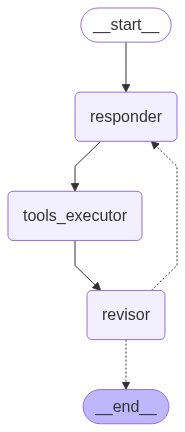

In [126]:
graph_builder = MessageGraph()

graph_builder.add_node(RESPONDER, responder_node)
graph_builder.add_node(TOOLS_EXECUTOR, execute_tools)
graph_builder.add_node(REVISOR, revisor_node)

graph_builder.set_entry_point(RESPONDER)
graph_builder.add_edge(RESPONDER, TOOLS_EXECUTOR)
graph_builder.add_edge(TOOLS_EXECUTOR, REVISOR)
graph_builder.add_conditional_edges(REVISOR, should_continue, path_map = {RESPONDER: RESPONDER, END: END})

graph = graph_builder.compile()
graph


In [130]:
blog_post = graph.invoke("Write a Twitter blog post in the topic of **LangGraph - The Game changer in Agentic AI World**.")

Failure during chat. (POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-06-11)
Status code: 429, body: {"errors":[{"code":"consumption_limit_reached","message":"The usage limit for the current plan has been reached: the total number of free concurrent requests for model ibm/granite-3-3-8b-instruct has reached its limit 10. Please try again later","more_info":"https://cloud.ibm.com/apidocs/watsonx-ai#text-chat"}],"trace":"e1c7adffe99190722458253bb8c354bc","status_code":429}


ApiRequestFailure: Failure during chat. (POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-06-11)
Status code: 429, body: {"errors":[{"code":"consumption_limit_reached","message":"The usage limit for the current plan has been reached: the total number of free concurrent requests for model ibm/granite-3-3-8b-instruct has reached its limit 10. Please try again later","more_info":"https://cloud.ibm.com/apidocs/watsonx-ai#text-chat"}],"trace":"e1c7adffe99190722458253bb8c354bc","status_code":429}